In [2]:

import pandas as pd
import numpy as np
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [7]:
import sys
from pathlib import Path

project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

# import my own modules
from CommonFunc.db_handler import DbHandler
from CommonFunc.fetch_update import FetcherUpdater

#### Update Data and Save to DB

In [11]:
# using absolute db path
db = DbHandler("D:\个人文件\个人发展\Git Projects\crypto-analysis\Data\crypto.db")
fetch_update = FetcherUpdater("D:\个人文件\个人发展\Git Projects\crypto-analysis\Data\crypto.db")

update_df = fetch_update.add_price_data(crypto='ETH', table='eth_hourly')
print(update_df)

            time                    utc_dt                    nyc_dt    high  \
2000  1738008000 2025-01-27 20:00:00+00:00 2025-01-27 15:00:00-05:00  3083.5   

          low     open   close  volumefrom     volumeto         avg  
2000  3073.99  3074.59  3081.3     5877.79  18098119.51  3079.06875  


In [ ]:
# # save to db if there's updated data
# if not update_df.empty:
#     db.save_to_db(update_df, 'eth_hourly')
# else:
#     print('Data is up-to-date')

#### Getting Data and Process Date Columns

In [12]:
# query eth price data
query = "SELECT * FROM eth_hourly order by time" # contains eth hourly data from 2018
df = db.read_from_db(query)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62013 entries, 0 to 62012
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        62013 non-null  int64  
 1   utc_dt      62013 non-null  object 
 2   nyc_dt      62013 non-null  object 
 3   high        62013 non-null  float64
 4   low         62013 non-null  float64
 5   open        62013 non-null  float64
 6   close       62013 non-null  float64
 7   volumefrom  62013 non-null  float64
 8   volumeto    62013 non-null  float64
 9   avg         62012 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 4.7+ MB
None


In [13]:
df['utc_dt'] = pd.to_datetime(df['utc_dt'])
df['nyc_dt'] = df['utc_dt'].apply(lambda x: x.astimezone(ZoneInfo("America/New_York")))

df['year'] = df['utc_dt'].dt.year
df['month'] = df['utc_dt'].dt.month
df['day'] = df['utc_dt'].dt.day
df['weekday'] = df['utc_dt'].dt.weekday # Monday=0, Sunday=6
df['hour'] = df['utc_dt'].dt.hour

#### Visualizing Pricing Trend

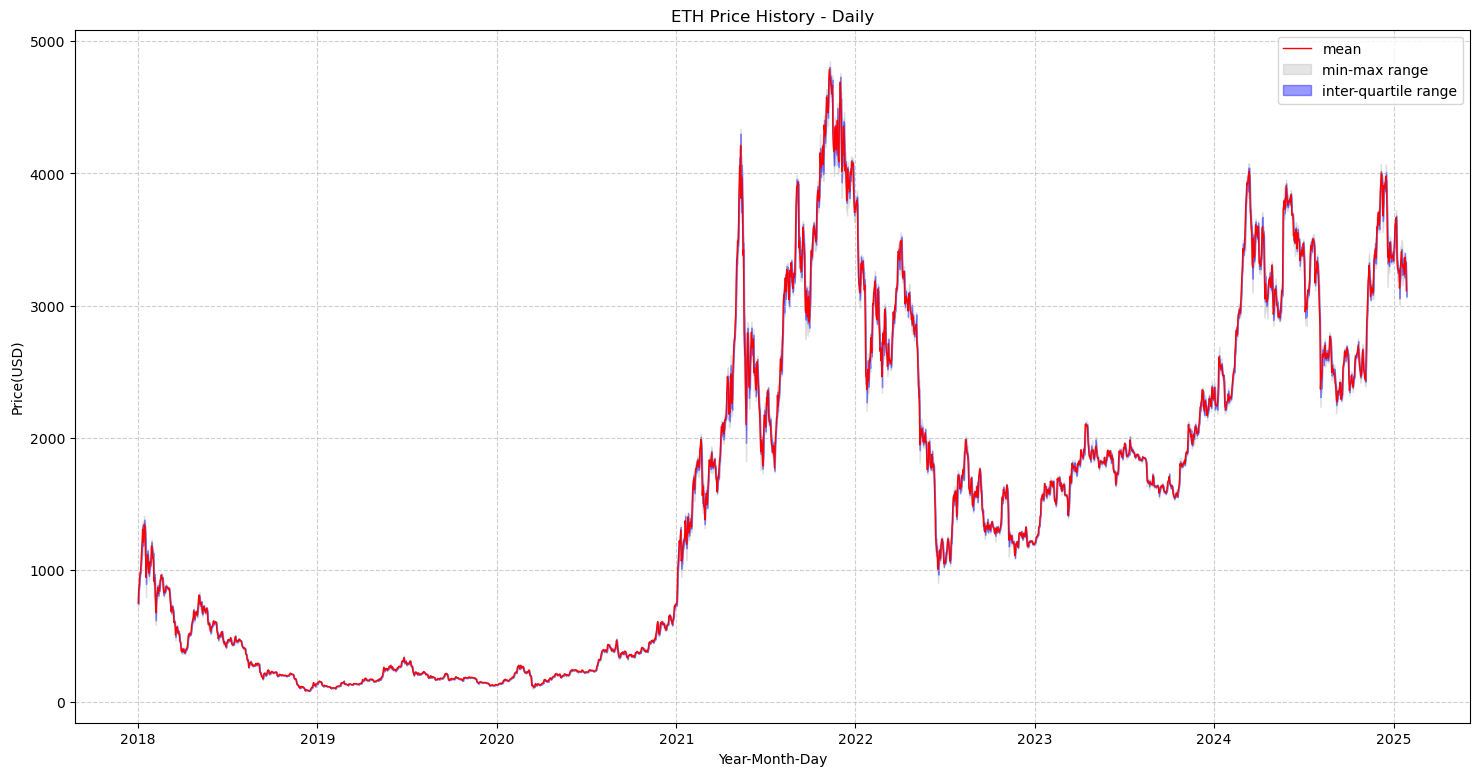

In [14]:
#-------------------- plot mean, min/max/25%/75%
#-----------by year/month/day
res = df.groupby(['year','month','day'])['avg'].describe().reset_index()
res['ymd'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-' + res['day'].astype(str))

crypto = 'ETH'

plt.figure(figsize=(18,9))

# mean
plt.plot(res['ymd'],res['mean'],'r-',label='mean',linewidth=1)
# range
plt.fill_between(res['ymd'], res['min'], res['max'], color='grey', alpha=0.2, label='min-max range')
plt.fill_between(res['ymd'], res['25%'], res['75%'], color='blue', alpha=0.4, label='inter-quartile range')

plt.title(f'{crypto} Price History - Daily')
plt.xlabel('Year-Month-Day')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

plt.show()

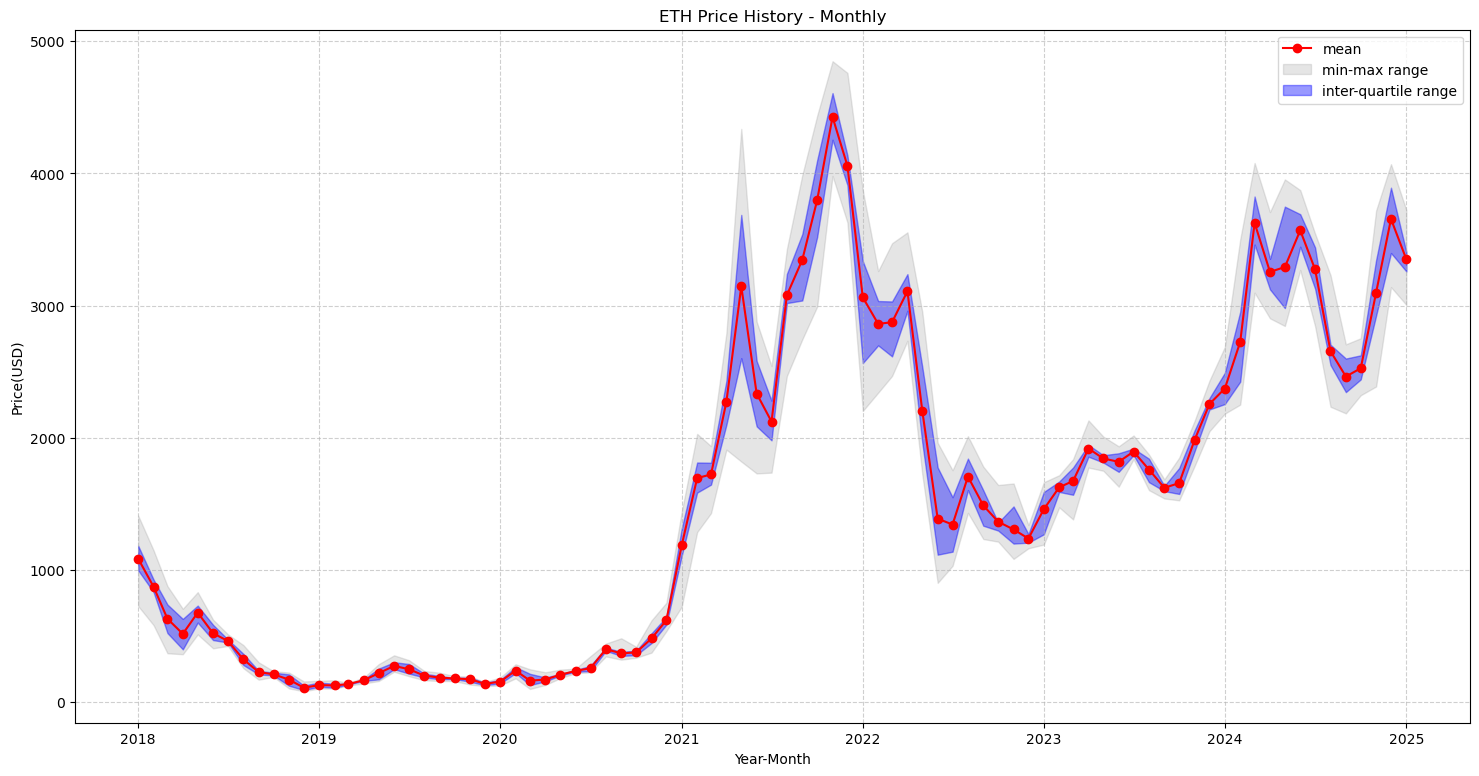

In [15]:
#-------------------- plot mean, min/max/25%/75%
#-----------by year/month
res = df.groupby(['year','month'])['avg'].describe().reset_index()
res['ym'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-01')

plt.figure(figsize=(18,9))

# mean
plt.plot(res['ym'],res['mean'],'ro-',label='mean')
# range
plt.fill_between(res['ym'], res['min'], res['max'], color='grey', alpha=0.2, label='min-max range')
plt.fill_between(res['ym'], res['25%'], res['75%'], color='blue', alpha=0.4, label='inter-quartile range')

plt.title(f'{crypto} Price History - Monthly')
plt.xlabel('Year-Month')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

plt.show()

#### A Glimpse at Price Fluctuation within a Month

ETH price fluctuation is more turbulent before 2023:
- It's generally safe to expect a range of 6*std within a month, which is roughly $1,500, or 40% to 45% of its highest price of the month.
- During the past year, high volatility is only seen in a few months - Feb, May, Nov (Election).

           ym         std    std_pct
36 2021-01-01  170.926342  14.388378
37 2021-02-01  172.356103  10.171401
38 2021-03-01  115.151915   6.684154
39 2021-04-01  224.336379   9.871186
40 2021-05-01  619.850748  19.701481
41 2021-06-01  302.381369  12.952826
42 2021-07-01  177.160378   8.348298
43 2021-08-01  240.958938   7.824839
44 2021-09-01  339.776094  10.154690
45 2021-10-01  331.485705   8.728245
46 2021-11-01  218.684387   4.939396
47 2021-12-01  236.693440   5.832628
48 2022-01-01  461.960737  15.084120
49 2022-02-01  202.288115   7.068415
50 2022-03-01  272.090435   9.466442
51 2022-04-01  200.568421   6.452032
52 2022-05-01  361.719959  16.420008
53 2022-06-01  320.036006  23.058260
54 2022-07-01  228.593927  17.017629
55 2022-08-01  143.979186   8.440064
56 2022-09-01  154.652265  10.395239
57 2022-10-01  104.818447   7.680794
58 2022-11-01  168.913922  12.931416
59 2022-12-01   40.006422   3.232820
60 2023-01-01  157.187919  10.770193
61 2023-02-01   59.439652   3.657547
6

<Figure size 1800x900 with 0 Axes>

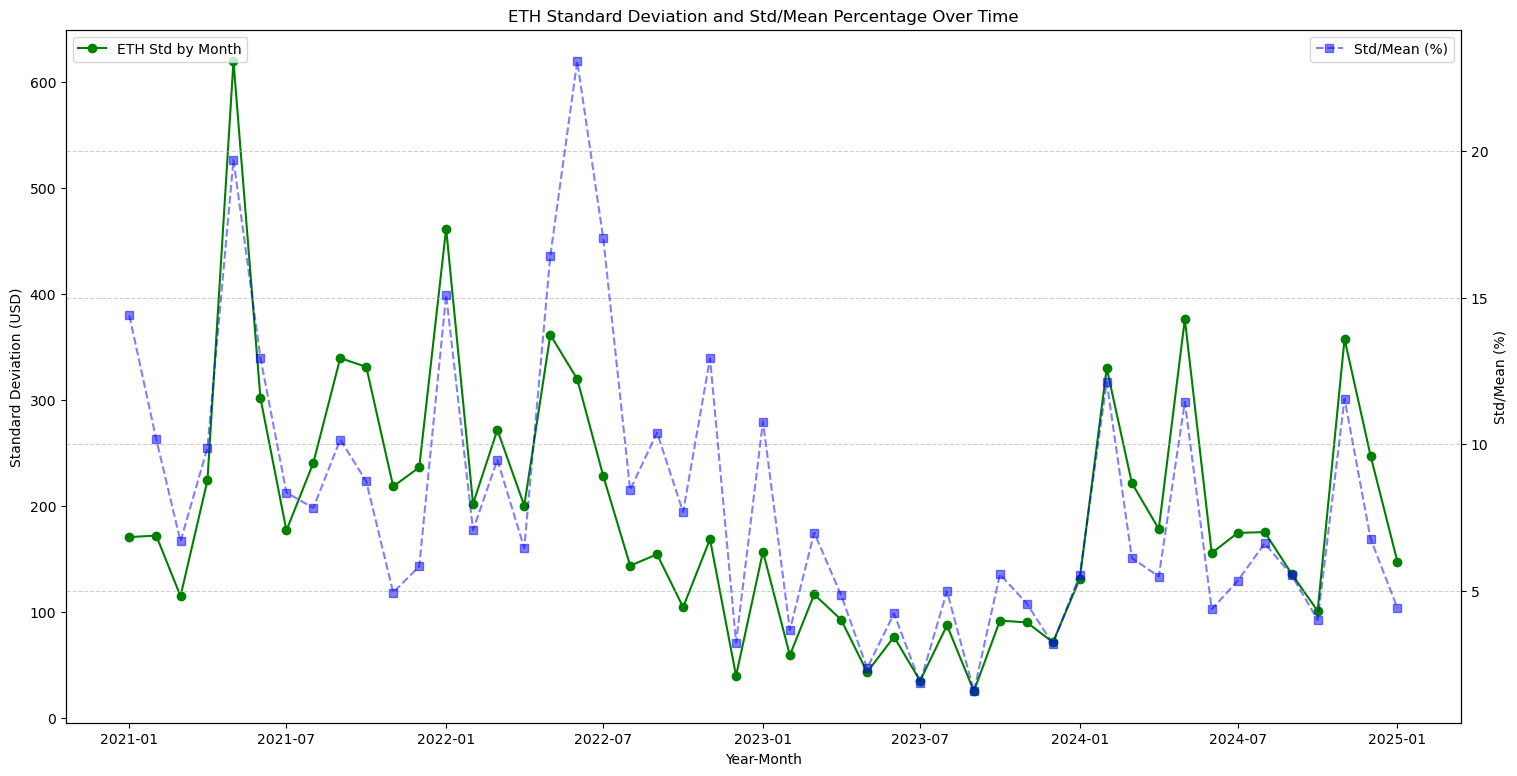

In [16]:
# plot std
#-----------by year/month
res = df.groupby(['year','month'])['avg'].describe().reset_index()
res['ym'] = pd.to_datetime(res['year'].astype(str) + '-' + res['month'].astype(str) + '-01')
res = res[res['year']>=2021]

plt.figure(figsize=(18,9))

# std/mean
res['std_pct'] = res['std']*100/res['mean']
print(res[['ym','std','std_pct']])

# plot with 2 axis
fig, ax1 = plt.subplots(figsize=(18,9))

ax1.plot(res['ym'],res['std'],'go-',label=f'{crypto} Std by Month')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Standard Deviation (USD)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(res['ym'],res['std_pct'],'bs--',label='Std/Mean (%)',alpha=0.5)
ax2.set_ylabel('Std/Mean (%)')
ax2.legend(loc='upper right')

plt.title(f'{crypto} Standard Deviation and Std/Mean Percentage Over Time')
plt.grid(linestyle='--', alpha=0.6)

#### Hourly Data Examination

Same as BTC, the ratio between Open/Close Range and High/Low Range is pretty much evenly distributed (<0.8) with a slight peak around 0.5, which means the open/close prices indicate very little about high/low prices.

count    9429.000000
mean        0.014184
std         0.513097
min        -0.990536
25%        -0.427766
50%         0.017172
75%         0.461538
max         0.997260
Name: ratio, dtype: float64


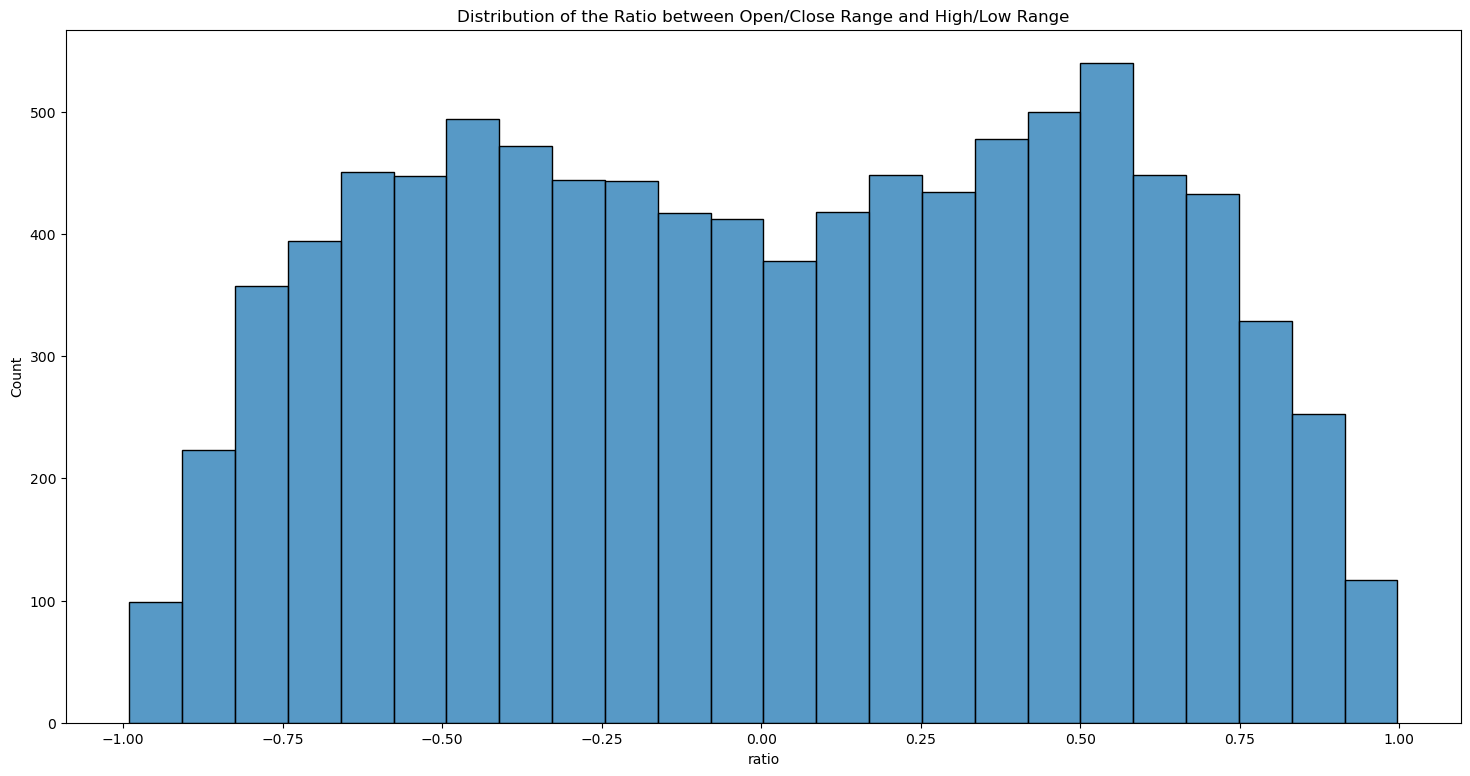

In [17]:
# hourly openclose/minmax ratio distribution
df['minmax_range'] = df['high'] - df['low']
df['openclose_range'] = df['close'] - df['open']
df['ratio'] = df['openclose_range']/df['minmax_range']

df24 = df[df['year']>=2024] 

print(df24['ratio'].describe())

plt.figure(figsize=(18,9))
sns.histplot(x=df24['ratio'])
plt.title('Distribution of the Ratio between Open/Close Range and High/Low Range')
plt.show()

ETH price fluctuation within an hour can be horrible - keep below numbers in mind when dealing contract
- ETH price can rise/drop more than 15% of its average trading price during an hour!
- Generally (in 95% of cases), ETH price change within an hour is less than 70, or roughly 2.2%

0.00      2.740
0.05      8.200
0.10     10.220
0.15     11.860
0.20     13.230
0.25     14.590
0.30     15.990
0.35     17.440
0.40     19.092
0.45     20.690
0.50     22.410
0.55     24.134
0.60     26.230
0.65     28.592
0.70     31.530
0.75     35.130
0.80     39.460
0.85     44.950
0.90     53.282
0.95     68.318
1.00    419.880
Name: minmax_range, dtype: float64


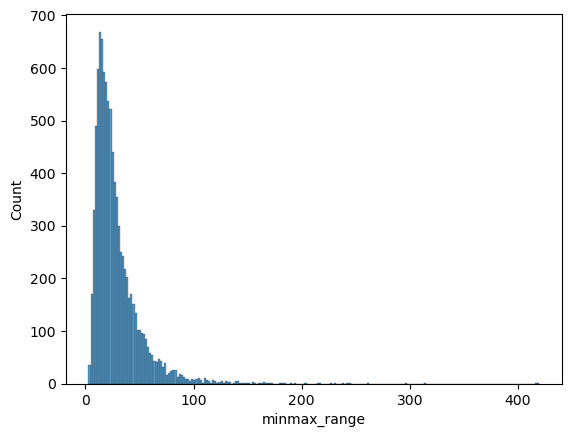

In [19]:
# minmax range distribution
print(df24['minmax_range'].quantile([x/20 for x in range(21)]))
sns.histplot(x=df24['minmax_range'])
plt.show()

0.00    0.001174
0.05    0.002942
0.10    0.003557
0.15    0.004075
0.20    0.004523
0.25    0.004943
0.30    0.005379
0.35    0.005860
0.40    0.006328
0.45    0.006795
0.50    0.007339
0.55    0.007908
0.60    0.008506
0.65    0.009244
0.70    0.010194
0.75    0.011311
0.80    0.012593
0.85    0.014282
0.90    0.016683
0.95    0.021579
1.00    0.165436
dtype: float64


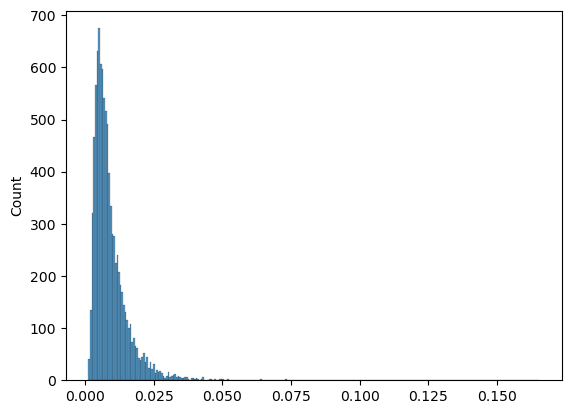

In [20]:
print((df24['minmax_range']/df24['open']).quantile([x/20 for x in range(21)]))
sns.histplot(x=df24['minmax_range']/df['open'])
plt.show()

There is high correlation (0.46) between the price change and the number of ETH traded - volume traded typically means higher price change.

In [21]:
# ABS trade volume change vs. price change after 2024
df24['abs_price_change'] = np.abs(df24['avg'] - df24['avg'].shift(1)) / df24['avg'].shift(1)
df24['abs_volume_change'] = np.abs(df24['volumefrom'] - df24['volumefrom'].shift(1))/ df24['avg'].shift(1)

# correlation between price change and volume traded
print(df24['abs_price_change'].corr(df24['abs_volume_change'])) # from hour to hour
print(np.abs(df24['openclose_range']).corr(df24['volumefrom'])) # within an hour

0.45986736897910374
0.48386774364439145


C:\Users\elisa\AppData\Local\Temp\ipykernel_33464\4293339652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['abs_price_change'] = np.abs(df24['avg'] - df24['avg'].shift(1)) / df24['avg'].shift(1)
C:\Users\elisa\AppData\Local\Temp\ipykernel_33464\4293339652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['abs_volume_change'] = np.abs(df24['volumefrom'] - df24['volumefrom'].shift(1))/ df24['avg'].shift(1)


In [24]:
# calculate price change within an hour
df24['price_pct_change'] = df24['openclose_range']*100/df24['open']
# print(df24['price_pct_change'].describe())

# Define surges and drops based on thresholds
price_surge_threshold = 0.05  
price_drop_threshold = -0.05 

df24['price_surge'] = df24['price_pct_change'] > price_surge_threshold
df24['price_drop'] = df24['price_pct_change'] < price_drop_threshold

C:\Users\elisa\AppData\Local\Temp\ipykernel_33464\2470375799.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['price_pct_change'] = df24['openclose_range']*100/df24['open']
C:\Users\elisa\AppData\Local\Temp\ipykernel_33464\2470375799.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df24['price_surge'] = df24['price_pct_change'] > price_surge_threshold
C:\Users\elisa\AppData\Local\Temp\ipykernel_33464\2470375799.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [25]:
# Define a helper function to calculate lasting periods
def calculate_periods(series):
    periods = []
    current_length = 0
    for value in series:
        if value:
            current_length += 1
        else:
            if current_length > 0:
                periods.append(current_length)
            current_length = 0
    if current_length > 0:
        periods.append(current_length)
    return periods

# Calculate lasting periods for price surges and drops
price_surge_periods = calculate_periods(df24['price_surge'])
price_drop_periods = calculate_periods(df24['price_drop'])

print(pd.Series(price_surge_periods).value_counts())
print(pd.Series(price_drop_periods).value_counts())

print("Price Surge Periods Statistics:", np.mean(price_surge_periods), np.std(price_surge_periods))
print("Price Drop Periods Statistics:", np.mean(price_drop_periods), np.std(price_drop_periods))

1     1426
2      627
3      284
4      105
5       47
6       17
7        6
9        2
8        1
13       1
dtype: int64
1     1437
2      650
3      230
4       93
5       47
6       11
7        3
8        2
9        2
12       1
10       1
dtype: int64
Price Surge Periods Statistics: 1.7368839427662957 1.102067930850714
Price Drop Periods Statistics: 1.6863140896245459 1.0638224601602135
